# MLP for new type of datasets

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

import pandas as pd
import numpy as np

# from tqdm import tqdm

import plotly.express as px
from torch.optim import Adam


import matplotlib.pyplot as plt

## Classes

In [2]:
class SequentDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, n_dots=1, n_dot_parameters=4):
        self.n_dot_parameters = n_dot_parameters
        self.n_dots = n_dots
        all_data = self.__make_stack(dataframe)
        self.X_ = all_data[:, :-n_dot_parameters]
        self.y_ = all_data[:, -n_dot_parameters:]

    def __len__(self):
        return len(self.X_)

    def __getitem__(self, idx):
        return self.X_[idx], self.y_[idx]

    def __make_stack(self, df: pd.DataFrame):
        stacks = [df.iloc[:-self.n_dots]] + [df.iloc[i:].values if (self.n_dots == i) else df.iloc[i:-(self.n_dots - i)].values for i in range(1, self.n_dots + 1)]
        return torch.tensor(np.hstack(stacks), dtype=torch.float32)

    def plotData(self, i = 0, f = -1):
        fig = px.line_3d(x = self.X_[i:f, 1], y = self.X_[i:f, 2], z = self.X_[i:f, 3])
        fig.show()

In [3]:
class DatasetForTrain(Dataset):
    def __init__(self, x, y):
        self.X_ = x
        self.y_ = y

    def __len__(self):
        return len(self.X_)

    def __getitem__(self, idx):
        return self.X_[idx], self.y_[idx]

In [4]:
class MLPModel(nn.Module):
    def __init__(self, input_dots_amount, input_dot_parameters_amount, output_dots_amount, output_dot_parameters_amount, hidden_layers_lengths, dropout_probability=0, activation=nn.ReLU()):
        super(MLPModel, self).__init__()
        self.layers = nn.ModuleList()
        layer_lengths = [input_dots_amount * input_dot_parameters_amount] + hidden_layers_lengths + [output_dots_amount * output_dot_parameters_amount]
        #self.dropout = nn.Dropout(dropout_probability)
        self.activation = activation
        for i in range(1, len(layer_lengths)):
            self.layers.append(nn.Linear(layer_lengths[i - 1], layer_lengths[i]))


    def forward(self, X: torch.Tensor):
        X = X.clone()
        for layer in self.layers[:-1]:
            X = layer(X)
            X = self.activation(X)
            #X = self.dropout(X)
        return self.layers[-1](X)

In [5]:
N_DOTS = 100

In [6]:
parab_train = pd.read_csv("../../sets_for_article/parab_train.csv")
parab_test = pd.read_csv("../../sets_for_article/parab_test.csv")

# dash_par_train = pd.read_csv("../sets_for_article//dash_slope_train.csv")
# dash_par_test = pd.read_csv("../sets_for_article//dash_slope_test.csv")

parab_train['t'] = 1
parab_test['t'] = 1

In [7]:
parab_train

t          X          Y          Z   I
0      1  -0.001037   0.000175  -0.000087   0
1      1   0.000148   0.099334  -0.049618   0
2      1   0.001789   0.198317  -0.098962   0
3      1   0.000591   0.301888  -0.150488   0
4      1  -0.001323   0.401743  -0.200065   0
...   ..        ...        ...        ...  ..
21956  1 -31.853508  54.444113 -41.235804  19
21957  1 -31.752992  54.363198 -41.378022  19
21958  1 -31.664456  54.291075 -41.502399  19
21959  1 -31.573882  54.218885 -41.630921  19
21960  1 -31.478070  54.143713 -41.767786  19

[21961 rows x 5 columns]

In [8]:
fig = px.line_3d(parab_train, x="X", y="Y", z="Z", color='I')
# fig = px.scatter_3d(data, x="X", y="Y", z="Z")
fig.show()

In [9]:
num_train = parab_train['I'].max()
dashes_train = []
# num_train=0
for i in range(num_train+1):
    temp = parab_train[parab_train['I'] == i]
    temp_dataset = SequentDataset(temp[['t','X','Y','Z']], N_DOTS, 4)
    dashes_train.append(temp_dataset)


num_test = parab_test['I'].max()
dashes_test = []
# num_test=0
for i in range(num_test+1):
    temp = parab_test[parab_test['I'] == i]
    temp_dataset = SequentDataset(temp[['t','X','Y','Z']], N_DOTS, 4)
    dashes_test.append(temp_dataset)

In [10]:
for_train_x = torch.zeros(1,dashes_train[0][0][0].size()[0])
for_train_y = torch.zeros(1,dashes_train[0][0][1].size()[0])
for dash in dashes_train:
    temp_x, temp_y = dash[:]
    # print(temp_x)
    # break
    for_train_x = torch.cat([for_train_x,temp_x],dim=0)
    for_train_y = torch.cat([for_train_y,temp_y],dim=0)

# Указание индекса строки, которую нужно удалить
row_index_to_delete = 0

# Генерация индексов строк, которые нужно сохранить
indices_to_keep = torch.tensor([i for i in range(for_train_x.size(0)) if i != row_index_to_delete])

for_train_x = torch.index_select(for_train_x, dim=0, index=indices_to_keep)
for_train_y = torch.index_select(for_train_y, dim=0, index=indices_to_keep)

train = DatasetForTrain(for_train_x, for_train_y)

In [11]:
dashes_train[0].plotData()

In [12]:
model = MLPModel(input_dots_amount=N_DOTS, input_dot_parameters_amount=4, output_dots_amount=1, output_dot_parameters_amount=4, hidden_layers_lengths=[256, 128, 64, 32])
# loss_model = nn.L1Loss()
loss_model = nn.HuberLoss()
# loss_model = nn.MSELoss()
opt = Adam(model.parameters(), lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1, gamma=0.5)

In [13]:
# model.load_state_dict(torch.load("mlp_angle_26_10.pt"))

In [14]:
EPOCH = 10
N_DASH = len(dashes_train)
train_losses = []
val_losses = []

train_data, val_data = random_split(train,[0.8,0.2])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

for epoch in range(EPOCH):

    # Обучение
    model.train()
    train_loss = []

    for X, y in train_loader:
        pred = model(X)
        loss = loss_model(pred, y)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()

        opt.step()
        mean_train_loss = sum(train_loss)/len(train_loss)

    train_losses.append(mean_train_loss)

    # Валидация
    model.eval()
    with torch.no_grad():
        val_loss = []
        for X, y in val_loader:
            pred = model(X)
            loss = loss_model(pred, y)
            val_loss.append(loss.item())

        mean_val_loss = sum(val_loss)/len(val_loss)
        val_losses.append(mean_val_loss)

    print(f"Epoch [{epoch+1}/{EPOCH}], train_loss = {mean_train_loss:.4f}, val_loss = {mean_val_loss:.4f}")

    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()

# for epoch in range(EPOCH):

#     n = 0

#     # Обучение
#     model.train()
#     train_loss = []

#     for dash in dashes_train:

#         n += 1
#         # train_data, val_data = random_split(dash,[0.8,0.2])

#         train_loader = DataLoader(dash, batch_size=8, shuffle=True)
#         # val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

#         for X, y in train_loader:
#             pred = model(X)
#             loss = loss_model(pred, y)
#             train_loss.append(loss.item())

#             opt.zero_grad()
#             loss.backward()

#             opt.step()
#             mean_train_loss = sum(train_loss)/len(train_loss)

#         train_losses.append(mean_train_loss)

#         # Валидация
#         # model.eval()
#         # with torch.no_grad():
#         #     val_loss = []
#         #     for X, y in val_loader:
#         #         pred = model(X)
#         #         loss = loss_model(pred, y)
#         #         val_loss.append(loss.item())

#         #     mean_val_loss = sum(val_loss)/len(val_loss)
#         #     val_losses.append(mean_val_loss)

#         # print(f"Epoch [{epoch+1}/{EPOCH}], train_loss = {mean_train_loss:.4f}, val_loss = {mean_val_loss:.4f}")
#         # print(f"Epoch [{epoch+1}/{EPOCH}], train_loss = {mean_train_loss:.4f}")

#     lr_scheduler.step()
#     lr = lr_scheduler.get_last_lr()
#     print("_"*20)
#     # print(f"Dashes [{n}/{N_DASH}], train_loss = {mean_train_loss:.4f}, val_loss = {mean_val_loss:.4f}")
#     print(f"Epoch [{epoch+1}/{EPOCH}], train_loss = {mean_train_loss:.4f}")
#     # print(f"Dashes [{n}/{N_DASH}], train_loss = {mean_train_loss:.4f}")
#     print("_"*20)

Epoch [1/10], train_loss = 4.8748, val_loss = 4.2803
Epoch [2/10], train_loss = 1.3668, val_loss = 1.2054
Epoch [3/10], train_loss = 0.5180, val_loss = 0.4839
Epoch [4/10], train_loss = 0.2023, val_loss = 0.2254
Epoch [5/10], train_loss = 0.0887, val_loss = 0.1142
Epoch [6/10], train_loss = 0.0527, val_loss = 0.0729
Epoch [7/10], train_loss = 0.0355, val_loss = 0.0315
Epoch [8/10], train_loss = 0.0284, val_loss = 0.0289
Epoch [9/10], train_loss = 0.0249, val_loss = 0.0249
Epoch [10/10], train_loss = 0.0231, val_loss = 0.0240


In [15]:
torch.save(model.state_dict(),"mlp_parab_28_10.pt")

<function matplotlib.pyplot.show(close=None, block=None)>

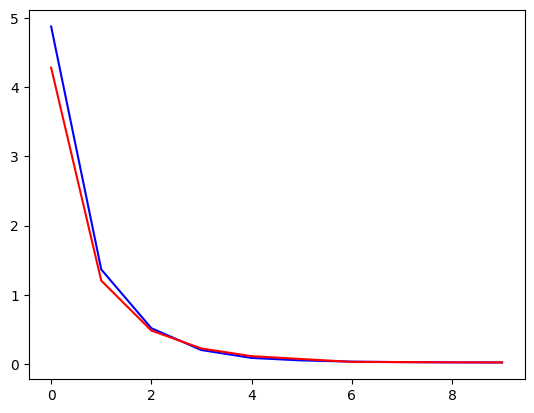

In [16]:
plt.plot(train_losses, '-b')
plt.plot(val_losses, '-r')
plt.show

In [17]:
all_predictions = []
all_true = []

for dash in dashes_train:
    start, _  = dash[0]
    predictions = []
    model.eval()

    for i in range(1,len(dash)):
        with torch.no_grad():
            pred = model(start)
            predictions.append(pred)
            start = torch.hstack([start[4:], pred])
            # start = pred
    _, y_true  = dash[:len(dash)]
    all_predictions.append(predictions)
    all_true.append(y_true)

In [18]:
pred_data = pd.DataFrame([[0,0,0,0,0]], columns=["Time", "X", "Y", "Z", "C"])

for i in range(len(all_predictions)):
    p_x = pd.DataFrame(map(lambda t: t.detach().tolist(), all_predictions[i]), columns=["Time", "X", "Y", "Z"])
    p_y = pd.DataFrame(all_true[i].detach().numpy(), columns=["Time", "X", "Y", "Z"])
    p_x["C"] = "Predict_" + str(i)
    p_y["C"] = "True_" + str(i)
    pred_data = pd.concat([pred_data,p_x,p_y],axis=0)

In [19]:
aaaab = pred_data.drop(pred_data.index[0], inplace=False)

In [20]:
bbbb = aaaab[(aaaab['C'] == 'Predict_2') | (aaaab['C'] == 'True_2')]

In [21]:
fig = px.line_3d(aaaab, x="X", y="Y", z="Z", color='C')
fig.show()